### Importing Libaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import torch
from TextCleaner import TextCleaner
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from scipy.special import softmax
from nltk.tokenize import sent_tokenize
from collections import Counter
import re
from wordcloud import WordCloud
import warnings
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
warnings.filterwarnings("ignore")

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Preload resources
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


c:\Users\yashj\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yashj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yashj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yashj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Getting Data

In [2]:
data = pd.read_csv('Data/Social Media Sentimental Analysis.csv')
data.columns = data.columns.str.lower()
data.head()

,text,sentiment,timestamp,user,platform,hashtags,retweets,likes,country,year,month,day,hour
0,Enjoying a beautiful day at the park! ...,Positive,15/01/2023 12:30,User123,Twitter,#Nature #Park,15,30,USA,2023,1,15,12
1,Traffic was terrible this morning. ...,Negative,15/01/2023 08:45,CommuterX,Twitter,#Traffic #Morning,5,10,Canada,2023,1,15,8
2,Just finished an amazing workout! 💪 ...,Positive,15/01/2023 15:45,FitnessFan,Instagram,#Fitness #Workout,20,40,USA,2023,1,15,15
3,Excited about the upcoming weekend getaway! ...,Positive,15/01/2023 18:20,AdventureX,Facebook,#Travel #Adventure,8,15,UK,2023,1,15,18
4,Trying out a new recipe for dinner tonight. ...,Neutral,15/01/2023 19:55,ChefCook,Instagram,#Cooking #Food,12,25,Australia,2023,1,15,19


### Data Exploration and Cleaning

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       732 non-null    object
 1   sentiment  732 non-null    object
 2   timestamp  732 non-null    object
 3   user       732 non-null    object
 4   platform   732 non-null    object
 5   hashtags   732 non-null    object
 6   retweets   732 non-null    int64 
 7   likes      732 non-null    int64 
 8   country    732 non-null    object
 9   year       732 non-null    int64 
 10  month      732 non-null    int64 
 11  day        732 non-null    int64 
 12  hour       732 non-null    int64 
dtypes: int64(6), object(7)
memory usage: 74.5+ KB


In [4]:
## Trimming the dataset

data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [5]:
data.duplicated().sum()

np.int64(22)

In [6]:
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

In [7]:
data.shape

(710, 13)

In [8]:
sentiment_counts = data['sentiment'].value_counts().head(7)
print(sentiment_counts)

sentiment
Positive       45
Joy            44
Excitement     37
Contentment    18
Neutral        18
Gratitude      17
Curiosity      16
Name: count, dtype: int64


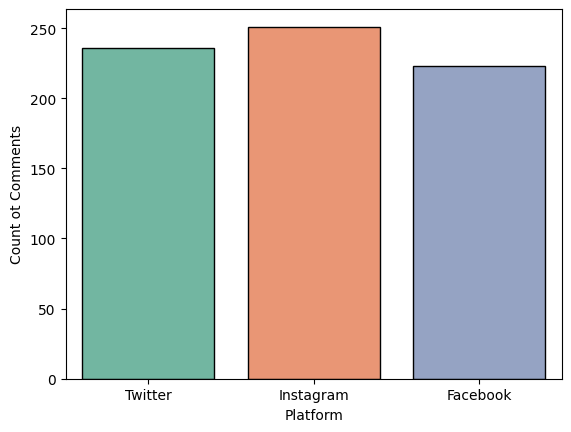

In [9]:
sns.countplot(x='platform', data=data,  palette='Set2', edgecolor='black')
plt.xlabel("Platform")
plt.ylabel("Count ot Comments")
plt.show()

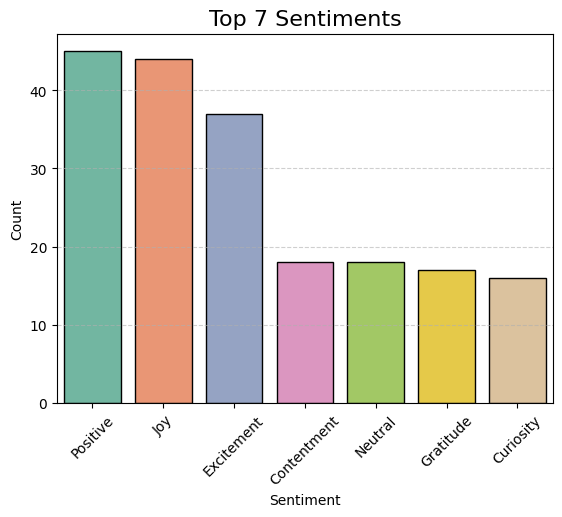

In [10]:
sns.barplot(x=data['sentiment'].value_counts().head(7).index, y=data['sentiment'].value_counts().head(7).values, palette='Set2', edgecolor='black')

plt.title('Top 7 Sentiments', fontsize=16)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)


In [11]:
data['hashtags_0'] = data['hashtags'].apply(lambda x: x.split(' ')[0].replace('#', '') if isinstance(x, str) else '')
data['hashtags_1'] = data['hashtags'].apply(lambda x: x.split(' ')[1].replace('#', '') if isinstance(x, str) else '')

In [12]:
data.drop(columns={'hashtags','user','timestamp'},inplace=True,axis=1)

In [13]:
## Engagement Analysis

data.groupby('platform').agg(
    retweet_mean=('retweets', 'mean'),
    retweet_max=('retweets', 'max'),
    retweet_sum=('retweets', 'sum'),
    retweet_count=('retweets', 'count'),
    like_mean=('likes', 'mean'),
    like_max=('likes', 'max'),
    like_sum=('likes', 'sum'),
    like_count=('likes', 'count')
).reset_index()


,platform,retweet_mean,retweet_max,retweet_sum,retweet_count,like_mean,like_max,like_sum,like_count
0,Facebook,20.964126,40,4675,223,41.856502,80,9334,223
1,Instagram,22.677291,40,5692,251,45.239044,80,11355,251
2,Twitter,20.902542,40,4933,236,41.644068,80,9828,236


In [14]:
data.nunique()

text          706
sentiment     191
platform        3
retweets       26
likes          38
country        33
year           14
month          12
day            31
hour           22
hashtags_0    372
hashtags_1    636
dtype: int64

In [15]:
raw_data = data.copy()

### Cleaning Review Text

In [16]:
#custom_stopwords = ['iphone', 'apple', 'camera', 'product', 'amazon', 'xr', 'x', 'phone','xs','authorize']
textCleaner = TextCleaner(remove_non_ascii=True, keep_currency_symbols=False,custom_keywords=None)
data['text']=data['text'].apply(textCleaner.clean)
data['raw_text']=raw_data['text'].copy()

In [17]:
data.head()

,text,sentiment,platform,retweets,likes,country,year,month,day,hour,hashtags_0,hashtags_1,raw_text
0,enjoy beautiful day park,Positive,Twitter,15,30,USA,2023,1,15,12,Nature,Park,Enjoying a beautiful day at the park!
1,traffic terrible morning,Negative,Twitter,5,10,Canada,2023,1,15,8,Traffic,Morning,Traffic was terrible this morning.
2,finish amaze workout,Positive,Instagram,20,40,USA,2023,1,15,15,Fitness,Workout,Just finished an amazing workout! 💪
3,excite upcoming weekend getaway,Positive,Facebook,8,15,UK,2023,1,15,18,Travel,Adventure,Excited about the upcoming weekend getaway!
4,try new recipe dinner tonight,Neutral,Instagram,12,25,Australia,2023,1,15,19,Cooking,Food,Trying out a new recipe for dinner tonight.


In [18]:
data.isna().sum()

text          0
sentiment     0
platform      0
retweets      0
likes         0
country       0
year          0
month         0
day           0
hour          0
hashtags_0    0
hashtags_1    0
raw_text      0
dtype: int64

In [19]:
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)
data = data[data.text!=''].copy()

In [20]:
data.shape

(709, 13)

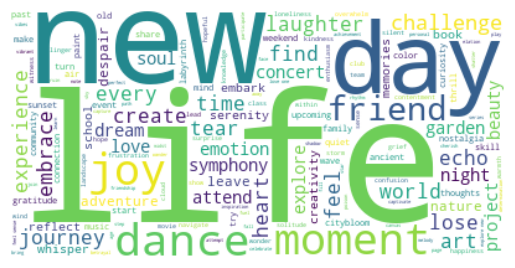

In [21]:
text = " ".join(review for review in data['text'])
wordcloud = WordCloud(background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Sentiment Analysis

#### TextBlob

In [22]:
data_textblob = data.copy()

In [23]:
polarity = []
subjectivity = []
for i in data_textblob['text'].values:
    try:
        analysis = TextBlob(i)
        polarity.append(analysis.sentiment.polarity)
        subjectivity.append(analysis.sentiment.subjectivity)
    except:
        polarity.append(0)
        subjectivity.append(0)

data_textblob['polarity'] = polarity
data_textblob['subjectivity'] = subjectivity

In [24]:
bins = np.linspace(-1, 1, 4) 
data_textblob['updated_rating'] = np.clip(np.digitize(data_textblob.polarity, bins, right=False), 1, 3)
data_textblob['sentiment'] =np.where( data_textblob['updated_rating'] < 2, 'Negative', np.where(data_textblob['updated_rating'] == 2, 'Neutral', 'Positive'))

In [25]:
data[['text_blob_polarity','text_blob_sentiment']] = data_textblob[['polarity','sentiment']].copy()

#### VADER

In [26]:
data_vader = data.copy()

In [27]:
vader_analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    scores = vader_analyzer.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        sentiment = "Positive"
    elif compound <= -0.05:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
    return pd.Series([sentiment, compound])

data_vader[['Sentiment', 'Compound_Score']] = data_vader['text'].apply(vader_sentiment)

In [28]:
data_vader.Sentiment.value_counts()

Sentiment
Positive    447
Negative    182
Neutral      80
Name: count, dtype: int64

In [29]:
data[['vader_score','vader_sentiment']] = data_vader[['Compound_Score','Sentiment']].copy()

#### RoBERTa

In [30]:
data_RoBERTa = data.copy()

In [31]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
RoBERTa_model = AutoModelForSequenceClassification.from_pretrained(MODEL)

RoBERTa_labels = ['Negative', 'Neutral', 'Positive']

def analyze_sentiment(text):
    encoded = tokenizer(text, return_tensors='pt', truncation=True)
    with torch.no_grad():
        output = RoBERTa_model(**encoded)
    scores = output.logits[0].numpy()
    probs = softmax(scores)
    sentiment = RoBERTa_labels[probs.argmax()]
    confidence = probs.max()
    return sentiment, confidence

data_RoBERTa[['Sentiment', 'Compound_Score']] = data_RoBERTa['text'].apply(lambda x: pd.Series(analyze_sentiment(x)))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [32]:
data_RoBERTa.Sentiment.value_counts()

Sentiment
Neutral     335
Positive    264
Negative    110
Name: count, dtype: int64

In [33]:
data[['RoBERTa_score','RoBERTa_sentiment']] = data_RoBERTa[['Compound_Score','Sentiment']].copy()

#### Zero-Shot Classification

In [34]:
data_zero = data.copy()

In [35]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
data_zero = data_zero[data_zero['text'].str.strip().ne("")]

#candidate_labels = data.sentiment.unique().tolist()
candidate_labels = ["Positive", "Negative", "Neutral"]

results = [classifier(text, candidate_labels) for text in data_zero.text]

Device set to use cpu


In [36]:
data_zero['Predicted_Sentiment'] = [res['labels'][0] for res in results]
data_zero['Confidence_score'] = [res['scores'][0] for res in results]

In [37]:
data_zero.Predicted_Sentiment.value_counts()

Predicted_Sentiment
Positive    467
Negative    208
Neutral      34
Name: count, dtype: int64

In [38]:
data[['zeroShot_score','zeroShot_sentiment']] = data_zero[['Confidence_score','Predicted_Sentiment']].copy()

#### GeoEmotions using BERT

In [39]:
tokenizer = AutoTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-original")
model = AutoModelForSequenceClassification.from_pretrained("monologg/bert-base-cased-goemotions-original")
model.eval()

GeoEmotions_labels = data.sentiment.unique().tolist()

# Your data (ensure 'review_text' column exists)
texts = data['text'].fillna('').tolist()

# Store results
dominant_emotion_labels = []
dominant_emotion_scores = []

# Batch processing
batch_size = 32
with torch.no_grad():
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        tokens = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
        outputs = model(**tokens)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()  # Multi-label output
        
        for prob in probs:
            max_idx = prob.argmax()
            dominant_emotion_labels.append(GeoEmotions_labels[max_idx])
            dominant_emotion_scores.append(prob[max_idx])

# Add to DataFrame
data['dominant_emotion'] = dominant_emotion_labels
data['emotion_score'] = np.round(dominant_emotion_scores,2)

100%|██████████| 23/23 [00:15<00:00,  1.51it/s]


### Comparing and Extracting the results

In [40]:
data.head()

,text,sentiment,platform,retweets,likes,country,year,month,day,hour,...,text_blob_polarity,text_blob_sentiment,vader_score,vader_sentiment,RoBERTa_score,RoBERTa_sentiment,zeroShot_score,zeroShot_sentiment,dominant_emotion,emotion_score
0,enjoy beautiful day park,Positive,Twitter,15,30,USA,2023,1,15,12,...,0.625000,Positive,0.7964,Positive,0.982089,Positive,0.893576,Positive,Acceptance,0.95
1,traffic terrible morning,Negative,Twitter,5,10,Canada,2023,1,15,8,...,-1.000000,Negative,-0.4767,Negative,0.916876,Negative,0.942568,Negative,Awe,0.98
2,finish amaze workout,Positive,Instagram,20,40,USA,2023,1,15,15,...,0.000000,Neutral,0.5423,Positive,0.707857,Neutral,0.878039,Positive,Shame,0.97
3,excite upcoming weekend getaway,Positive,Facebook,8,15,UK,2023,1,15,18,...,0.000000,Neutral,0.4767,Positive,0.983746,Positive,0.976076,Positive,Affection,0.98
4,try new recipe dinner tonight,Neutral,Instagram,12,25,Australia,2023,1,15,19,...,0.136364,Neutral,0.0000,Neutral,0.741249,Neutral,0.695703,Positive,Elation,1.00


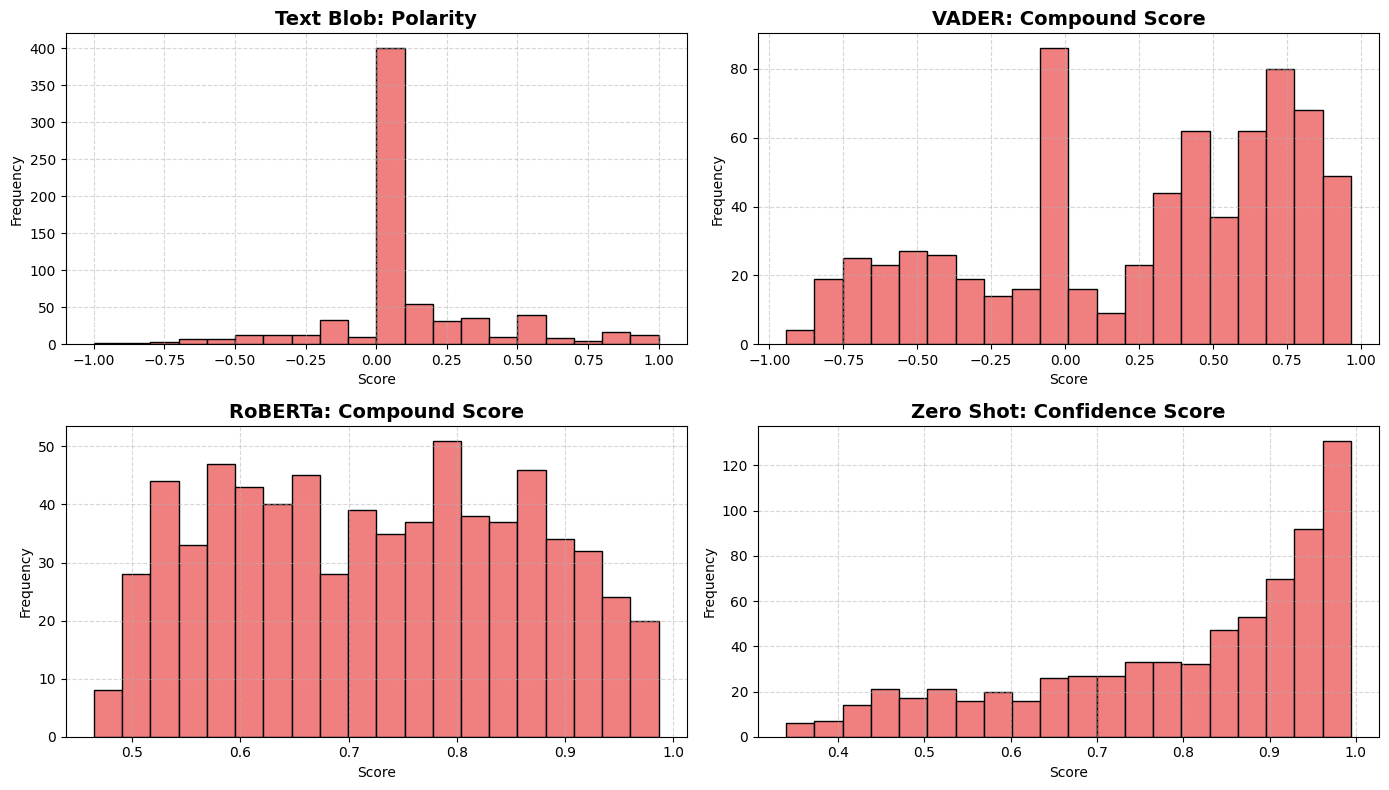

In [41]:
scores = ['Polarity', 'Compound Score', 'Compound Score', 'Confidence Score']
columns = ['text_blob_polarity','vader_score','RoBERTa_score','zeroShot_score']
titles = ['Text Blob', 'VADER', 'RoBERTa', 'Zero Shot']

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

# Loop through datasets and plot histograms
for i,column in enumerate(columns):
    axes[i].hist(data[column], bins=20, color='lightcoral', edgecolor='black')
    axes[i].set_title(f"{titles[i]}: {scores[i]}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Layout fix
plt.tight_layout()
plt.show()

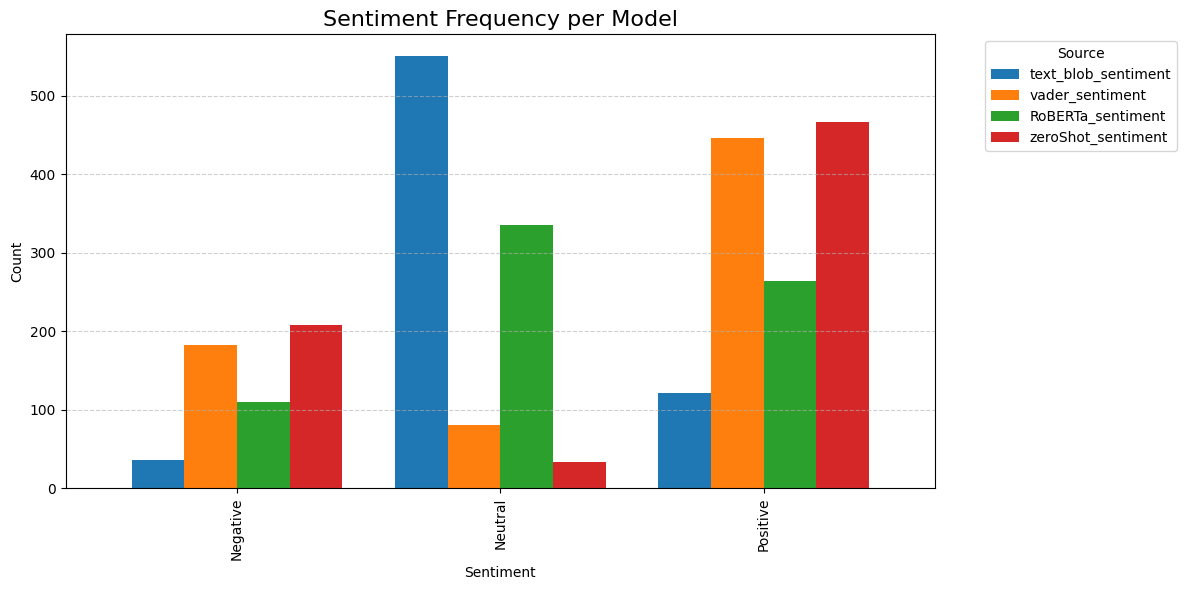

In [42]:
## Plotting Sentiment counts

sentiment_counts = pd.DataFrame()
for col in ['text_blob_sentiment', 'vader_sentiment', 'RoBERTa_sentiment', 'zeroShot_sentiment']:
    sentiment_counts[col] = data[col].value_counts().sort_index()

sentiment_counts = sentiment_counts.fillna(0).astype(int)

sentiment_counts.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('Sentiment Frequency per Model', fontsize=16)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


* From both the above graph we can disregard Zeroshot and Textblob sentimental analyis. <b>Textblob</b> is skewed towards neutal reviews while <b>Zeroshot</b> is skewed towards positive reviews.
* We are going to continue the analysis with <b>RoBERTa</b> and <b>Vader</b> Model.

#### Classification of user_sentiment into 3 sentiments using Vader and RoBERTa

In [43]:
data_user = pd.DataFrame(data['sentiment'].unique(),columns=['sentiment'])
data_user.head()

,sentiment
0,Positive
1,Negative
2,Neutral
3,Anger
4,Fear


In [44]:
## Vader
data_user[['vader_sentiment', 'Vader_Compound_Score']] = data_user['sentiment'].apply(vader_sentiment)

In [45]:
## RoBERTa
data_user[['RoBERTa_sentiment', 'RoBERTa_Compound_Score']] = data_user['sentiment'].apply(lambda x: pd.Series(analyze_sentiment(x)))

In [46]:
### Get Differnces 
def majority_vote(row):
    sentiments = [ 
        row['vader_sentiment'],
        row['RoBERTa_sentiment'],
    ]
    count = Counter(sentiments)
    most_common = count.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 'Ambiguous'
    else:
        return most_common[0][0]

In [47]:
data_user['ensemble'] = data_user.apply(majority_vote,axis=1)
data_user[data_user['ensemble'] == 'Ambiguous'][['sentiment','vader_sentiment','RoBERTa_sentiment']]

,sentiment,vader_sentiment,RoBERTa_sentiment
0,Positive,Positive,Neutral
1,Negative,Negative,Neutral
3,Anger,Negative,Neutral
4,Fear,Negative,Neutral
5,Sadness,Negative,Neutral
...,...,...,...
185,Embarrassed,Negative,Neutral
187,Sad,Negative,Neutral
188,Hate,Negative,Neutral
189,Bad,Negative,Neutral


* Based on <b>Ambiguous</b> list, <b>VADER</b> is better match the compare the user_sentiment with the overall sentiment of the statement

#### Merging the Datasets for final evaluation

In [48]:
final_df = raw_data.copy()
final_df['clean_text'] = data['text'].copy()
final_df=final_df.merge(data_user[['sentiment','vader_sentiment']],left_on='sentiment', right_on='sentiment', how='left')
final_df.rename(columns={'sentiment':'user_emotions','vader_sentiment':'user_sentiment'},inplace=True)
final_df['day_name'] = pd.to_datetime(final_df[['year', 'month', 'day']]).dt.day_name()
final_df[['vader_score','vader_sentiment','RoBERTa_score','RoBERTa_sentiment']] = data[['vader_score','vader_sentiment','RoBERTa_score','RoBERTa_sentiment']].copy()
final_df['is_weekend'] = np.where(final_df['day'].isin(['Saturday', 'Sunday']),'Weekend','Weekday')
final_df['time'] = np.where(final_df['hour'] < 5, 'Late Night',
                    np.where(final_df['hour'] < 10, 'Morning',
                    np.where(final_df['hour'] < 15, 'Midday',
                    np.where(final_df['hour'] < 20, 'Evening', 'Night'))))

In [49]:
final_df =  final_df[['text', 'clean_text', 'platform', 'retweets', 'likes', 'country', 'hashtags_0', 'hashtags_1','day_name','is_weekend','time','user_emotions'
       , 'user_sentiment', 'vader_score', 'vader_sentiment',
       'RoBERTa_score', 'RoBERTa_sentiment']]

In [50]:
final_df.drop_duplicates(inplace=True)
final_df.dropna(inplace=True)

In [51]:
final_df.shape

(686, 17)

In [52]:
final_df.head()

,text,clean_text,platform,retweets,likes,country,hashtags_0,hashtags_1,day_name,is_weekend,time,user_emotions,user_sentiment,vader_score,vader_sentiment,RoBERTa_score,RoBERTa_sentiment
0,Enjoying a beautiful day at the park!,enjoy beautiful day park,Twitter,15,30,USA,Nature,Park,Sunday,Weekday,Midday,Positive,Positive,0.7964,Positive,0.982089,Positive
1,Traffic was terrible this morning.,traffic terrible morning,Twitter,5,10,Canada,Traffic,Morning,Sunday,Weekday,Morning,Negative,Negative,-0.4767,Negative,0.916876,Negative
2,Just finished an amazing workout! 💪,finish amaze workout,Instagram,20,40,USA,Fitness,Workout,Sunday,Weekday,Evening,Positive,Positive,0.5423,Positive,0.707857,Neutral
3,Excited about the upcoming weekend getaway!,excite upcoming weekend getaway,Facebook,8,15,UK,Travel,Adventure,Sunday,Weekday,Evening,Positive,Positive,0.4767,Positive,0.983746,Positive
4,Trying out a new recipe for dinner tonight.,try new recipe dinner tonight,Instagram,12,25,Australia,Cooking,Food,Sunday,Weekday,Evening,Neutral,Neutral,0.0000,Neutral,0.741249,Neutral


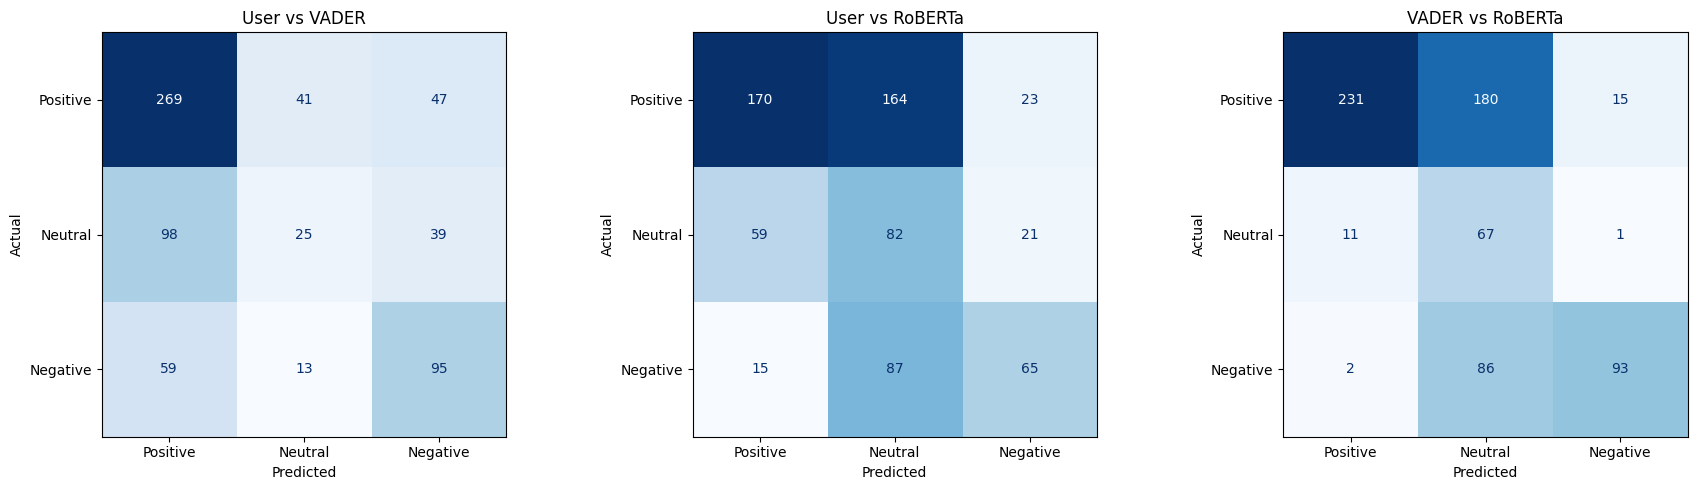

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels=["Positive", "Neutral", "Negative"]
# Pairwise confusion matrices
pairs = [
    ("User vs VADER", final_df['user_sentiment'], final_df['vader_sentiment']),
    ("User vs RoBERTa", final_df['user_sentiment'], final_df['RoBERTa_sentiment']),
    ("VADER vs RoBERTa", final_df['vader_sentiment'], final_df['RoBERTa_sentiment']),
]

# Plot each on a different subplot
for ax, (title, true, pred) in zip(axes, pairs):
    cm = confusion_matrix(true, pred, labels=labels)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [54]:
### Getting final sentiment based on majority of votes
def get_majority_sentiment(row):
    sentiments = [row['user_sentiment'], row['vader_sentiment'], row['RoBERTa_sentiment']]
    return Counter(sentiments).most_common(1)[0][0]

final_df['final_sentiment'] = final_df.apply(get_majority_sentiment, axis=1)


In [55]:
final_df.final_sentiment.value_counts()

final_sentiment
Positive    377
Negative    176
Neutral     133
Name: count, dtype: int64

#### Hypothesis Testing

In [56]:
from scipy.stats import chi2_contingency
def check_contingency(col1,col2,data):
    print(f'=====> Checking hypothesis for {str.title(str.replace(col1,'_',' '))} with {str.title(str.replace(col2,'_',' '))}\n')
    contingency = pd.crosstab(data[col1], data[col2])
    chi2, p, dof, ex = chi2_contingency(contingency)

    print("Chi-square statistic:", chi2)
    print("p-value:", p)
    print("Degrees of freedom:", dof)

    if p < 0.05:
        print(f'Reject null hypothesis — sentiment varies by {str.title(str.replace(col1,'_',' '))}.')
    else:
        print(f'Fail to reject null — no significant difference in sentiment across {str.title(str.replace(col1,'_',' '))}.')

In [57]:
check_contingency('platform','final_sentiment',final_df)

=====> Checking hypothesis for Platform with Final Sentiment

Chi-square statistic: 1.557015218522973
p-value: 0.816496201796831
Degrees of freedom: 4
Fail to reject null — no significant difference in sentiment across Platform.


In [58]:
check_contingency('country','final_sentiment',final_df)

=====> Checking hypothesis for Country with Final Sentiment

Chi-square statistic: 67.13421364777317
p-value: 0.3701848328895724
Degrees of freedom: 64
Fail to reject null — no significant difference in sentiment across Country.


In [59]:
check_contingency('hashtags_0','final_sentiment',final_df)

=====> Checking hypothesis for Hashtags 0 with Final Sentiment

Chi-square statistic: 1136.745668956598
p-value: 1.6560392114446227e-19
Degrees of freedom: 738
Reject null hypothesis — sentiment varies by Hashtags 0.


In [60]:
check_contingency('hashtags_1','final_sentiment',final_df)

=====> Checking hypothesis for Hashtags 1 with Final Sentiment

Chi-square statistic: 1293.3795931269274
p-value: 0.09510883056878416
Degrees of freedom: 1228
Fail to reject null — no significant difference in sentiment across Hashtags 1.


In [61]:
check_contingency('day_name','final_sentiment',final_df)

=====> Checking hypothesis for Day Name with Final Sentiment

Chi-square statistic: 5.585338060877309
p-value: 0.9355272056158159
Degrees of freedom: 12
Fail to reject null — no significant difference in sentiment across Day Name.


In [62]:
check_contingency('time','final_sentiment',final_df)

=====> Checking hypothesis for Time with Final Sentiment

Chi-square statistic: 5.461118470207213
p-value: 0.7073438308395747
Degrees of freedom: 8
Fail to reject null — no significant difference in sentiment across Time.


In [63]:
check_contingency('is_weekend','final_sentiment',final_df)

=====> Checking hypothesis for Is Weekend with Final Sentiment

Chi-square statistic: 0.0
p-value: 1.0
Degrees of freedom: 0
Fail to reject null — no significant difference in sentiment across Is Weekend.


* The hypothesis testing indicates that hashtags play a statistically significant role in determining the sentiment of a text, independent of the textual content itself.

#### Sentiment Trends (Patterns Over Time or Category)

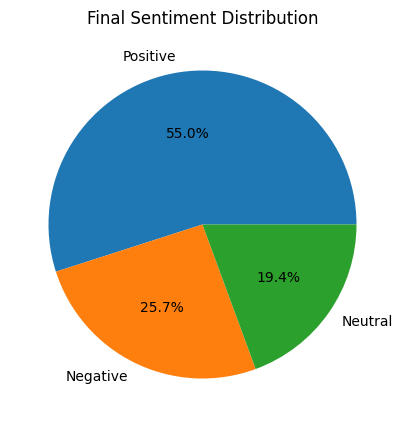

In [64]:
sentiment_counts = final_df['final_sentiment'].value_counts()
plt.figure(figsize=(5,5))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%'
)
plt.title('Final Sentiment Distribution')
plt.show()


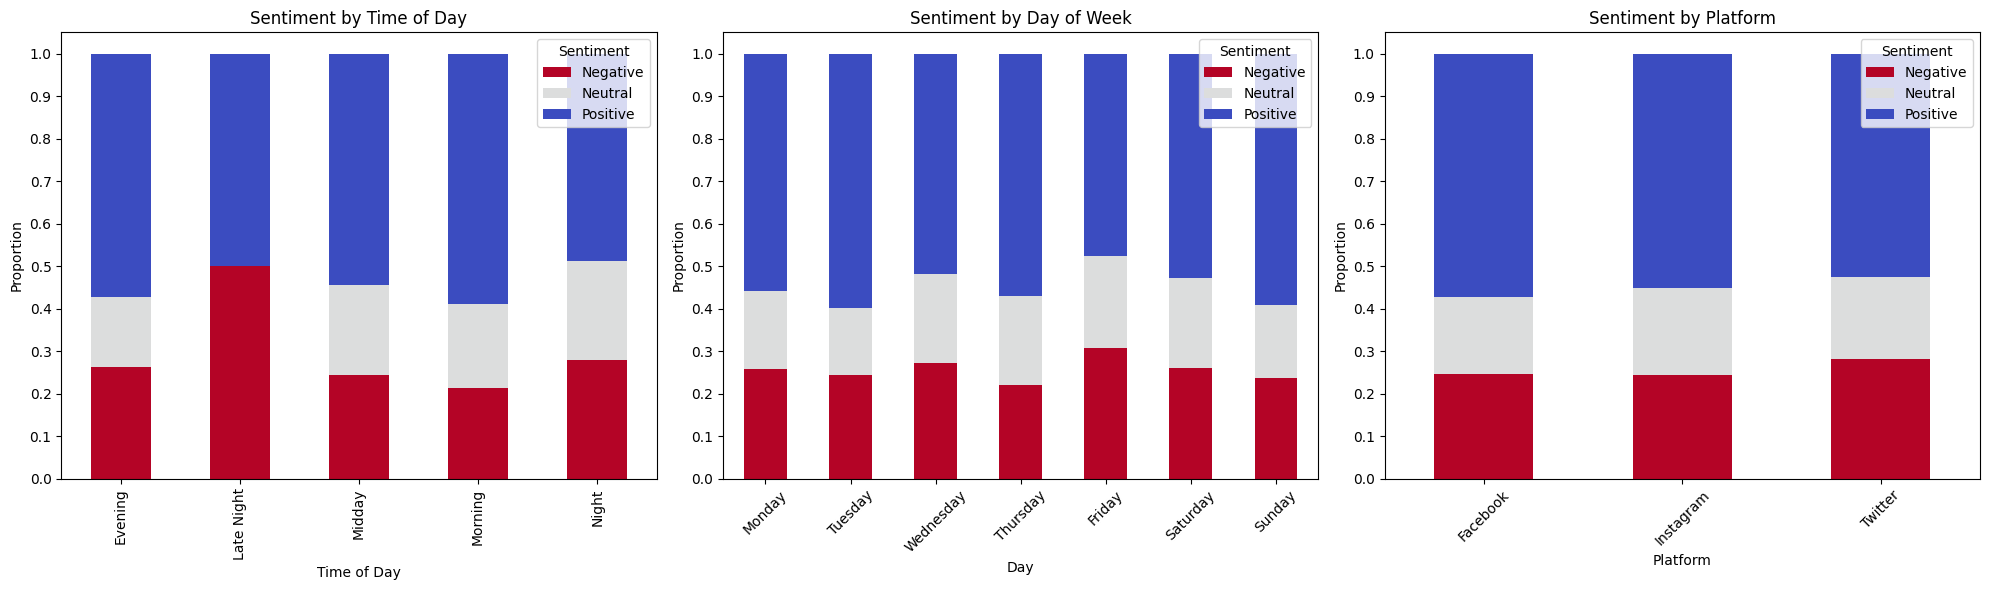

In [65]:
from matplotlib.ticker import MultipleLocator

ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
final_df['day_name'] = pd.Categorical(final_df['day_name'], categories=ordered_days, ordered=True)

time_sentiment = final_df.groupby('time')['final_sentiment'].value_counts(normalize=True).unstack()
day_sentiment = final_df.groupby('day_name')['final_sentiment'].value_counts(normalize=True).unstack()
platform_sentiment = final_df.groupby('platform')['final_sentiment'].value_counts(normalize=True).unstack()

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Sentiment by Time of Day
time_sentiment.plot(
    kind='bar',
    stacked=True,
    colormap='coolwarm_r',
    ax=axes[0]
)
axes[0].set_title('Sentiment by Time of Day')
axes[0].set_ylabel('Proportion')
axes[0].set_xlabel('Time of Day')
axes[0].legend(title='Sentiment', loc='upper right')
axes[0].yaxis.set_major_locator(MultipleLocator(0.1)) 

# Plot 2: Sentiment by Day of Week
day_sentiment.plot(
    kind='bar',
    stacked=True,
    colormap='coolwarm_r',
    ax=axes[1]
)
axes[1].set_title('Sentiment by Day of Week')
axes[1].set_ylabel('Proportion')
axes[1].set_xlabel('Day')
axes[1].legend(title='Sentiment', loc='upper right')
axes[1].tick_params(axis='x', rotation=45)
axes[1].yaxis.set_major_locator(MultipleLocator(0.1)) 


# Plot 3: Sentiment by Platform
platform_sentiment.plot(
    kind='bar',
    stacked=True,
    colormap='coolwarm_r',
    ax=axes[2]
)
axes[2].set_title('Sentiment by Platform')
axes[2].set_ylabel('Proportion')
axes[2].set_xlabel('Platform')
axes[2].legend(title='Sentiment', loc='upper right')
axes[2].tick_params(axis='x', rotation=45)
axes[2].yaxis.set_major_locator(MultipleLocator(0.1))

plt.tight_layout()
plt.show()

* Late Night shows the highest negative sentiment among all time periods. Morning and Midday have the most positive sentiment overall.
* Friday and Saturday show a slight increase in negative sentiment.
* Twitter has a higher proportion of negative sentiment compared to Facebook and Instagram.
* Positive sentiment remains the dominant emotion across all days and platforms.

#### Extracting top Positive/Negative Words using VADER with RoBERTa as base

In [66]:
def extract_pos_neg_words(text):
    words = re.findall(r'\b\w+\b', text.lower())  # tokenize words
    pos_words, neg_words = [], []
    for word in words:
        score = vader_analyzer.polarity_scores(word)['compound']
        if score >= 0.5:
            pos_words.append(word)
        elif score <= -0.5:
            neg_words.append(word)
    return pos_words, neg_words

In [67]:
cluster_pos_words = {}
cluster_neg_words = {}

for cluster, group in final_df.groupby('final_sentiment'):
    all_pos = []
    all_neg = []
    for review in group['clean_text']:
        pos, neg = extract_pos_neg_words(str(review))
        all_pos.extend(pos)
        all_neg.extend(neg)
    cluster_pos_words[cluster] = Counter(all_pos).most_common(10)
    cluster_neg_words[cluster] = Counter(all_neg).most_common(10)

In [68]:
def plot_pos_neg_words(pos_words, neg_words, title="Top Sentiment Words"):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    if pos_words:
        words, counts = zip(*pos_words)
        axes[0].barh(words, counts, color='green')
        axes[0].set_title("Positive Words")
        axes[0].invert_yaxis()
    else:
        axes[0].text(0.5, 0.5, 'No Positive Words', ha='center', va='center')
        axes[0].axis('off')
    
    if neg_words:
        words, counts = zip(*neg_words)
        axes[1].barh(words, counts, color='red')
        axes[1].set_title("Negative Words")
        axes[1].invert_yaxis()
    else:
        axes[1].text(0.5, 0.5, 'No Negative Words', ha='center', va='center')
        axes[1].axis('off')
    
    for ax in axes:
        ax.set_xlabel("Frequency")
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

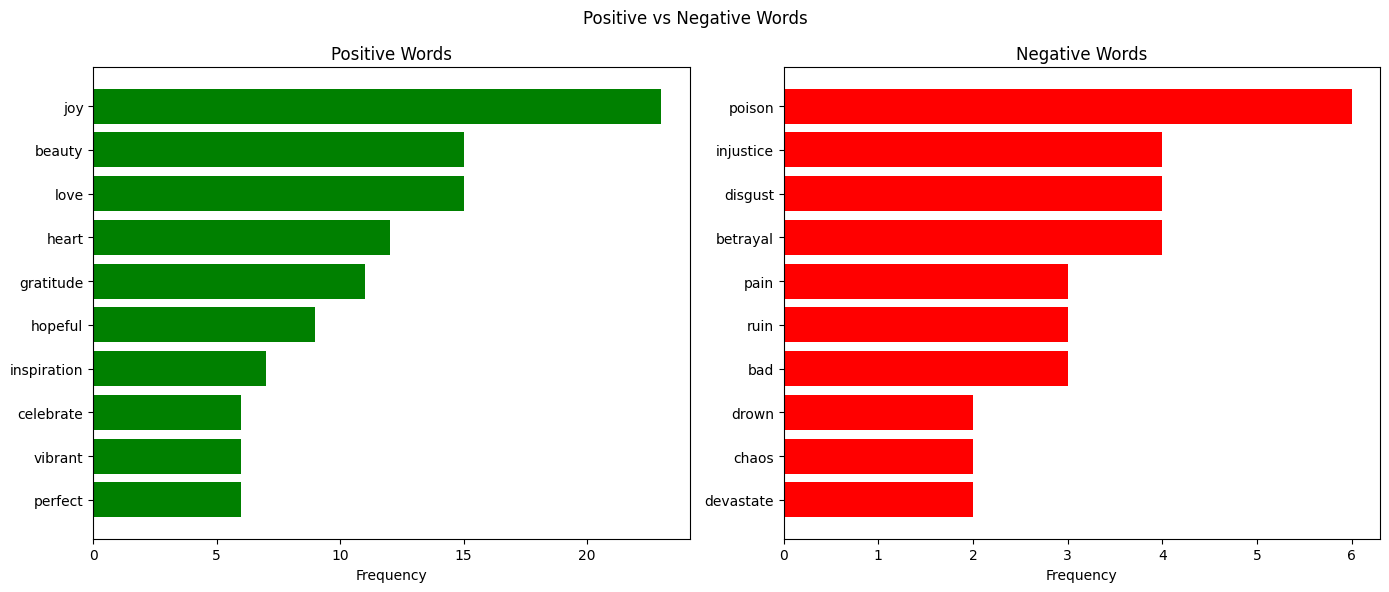

In [69]:
plot_pos_neg_words(cluster_pos_words['Positive'], cluster_neg_words['Negative'], title="Positive vs Negative Words")

#### Top Positive and Negtative Sentences + Hashtags

In [70]:
positive_sentences = []
negative_sentences = []

# Replace this with your actual column:
text_column = final_df['text']

for review in text_column.dropna():
    sentences = sent_tokenize(review)
    for sentence in sentences:
        score = vader_analyzer.polarity_scores(sentence)['compound']
        if score >= 0.7:
            positive_sentences.append(sentence)
        elif score <= -0.3:
            negative_sentences.append(sentence)

            
print("🟢 Top 10 Positive Sentences:")
for s in positive_sentences[:10]:
    print("-", s)

print("\n🔴 Top 10 Negative Sentences:")
for s in negative_sentences[:10]:
    print("-", s)


🟢 Top 10 Positive Sentences:
- Enjoying a beautiful day at the park!
- Just adopted a cute furry friend!
- Sipping coffee and enjoying a good book.
- Cooking a special dinner for loved ones.
- Pure happiness: celebrating a loved one's achievement!
- Laughter is the best medicine—enjoying a comedy show.
- Sharing love and positive vibes with everyone!
- An amusing incident brightened up my day!
- Admiring the beauty of nature during a peaceful hike.
- A surprise gift from a friend made my day!

🔴 Top 10 Negative Sentences:
- Traffic was terrible this morning.
- Feeling a sense of fear after watching a thriller movie.
- Heartbroken after hearing the news about a natural disaster.
- The state of the world's environment is just disgusting.
- Disappointed with the service at a local restaurant.
- A moment of shame for not standing up against injustice.
- Fuming with anger after a heated argument.
- The fear of the unknown is keeping me up at night.
- The state of corruption in our society i

In [73]:
hashtags_cols = ['hashtags_0', 'hashtags_1']

## Melt hashtags columns keeping vader_sentiment and vader_score
hashtags_df = final_df.melt(
    id_vars=['final_sentiment', 'vader_score'],
    value_vars=hashtags_cols,
    value_name='hashtag'
).dropna(subset=['hashtag'])

## Remove empty hashtags
hashtags_df = hashtags_df[hashtags_df['hashtag'] != '']

## Aggregate mean vader_score and count per sentiment-hashtag
hashtag_scores = (
    hashtags_df.groupby(['final_sentiment', 'hashtag'])
               .agg(mean_vader_score=('vader_score', 'mean'),
                    count=('hashtag', 'size'))
               .reset_index()
)

## Get top 10 hashtags per vader_sentiment by mean vader_score
top_10_per_sentiment = (
    hashtag_scores.groupby('final_sentiment')
                  .apply(lambda x: x.nlargest(5, 'mean_vader_score'))
                  .reset_index(drop=True)
)

## Emoji mapping for sentiments
emoji_map = {
    'Positive': '🟢',
    'Negative': '🔴',
    'Neutral': '🟡',
}

## Print top 10 hashtags by sentiment with emojis
for sentiment in top_10_per_sentiment['final_sentiment'].unique():
    emoji = emoji_map.get(sentiment, '🔵')
    print(f"{emoji} Top 5 {sentiment} Hashtags:")
    
    hashtags = top_10_per_sentiment[top_10_per_sentiment['final_sentiment'] == sentiment]['hashtag'].tolist()
    for tag in hashtags:
        print(f"- #{tag}")
    print()


🔴 Top 5 Negative Hashtags:
- #CrushFail
- #BadLuckDay
- #BitterPill
- #InstrumentLearning
- #TeenMusic

🟡 Top 5 Neutral Hashtags:
- #MarketStories
- #Vibrancy
- #CulturalDay
- #TeenCuriosity
- #Connection

🟢 Top 5 Positive Hashtags:
- #Miscalculation
- #SwimmingDisappointment
- #ClassEvent
- #TeenExcitement
- #Charm



#### N-Grams Analysis

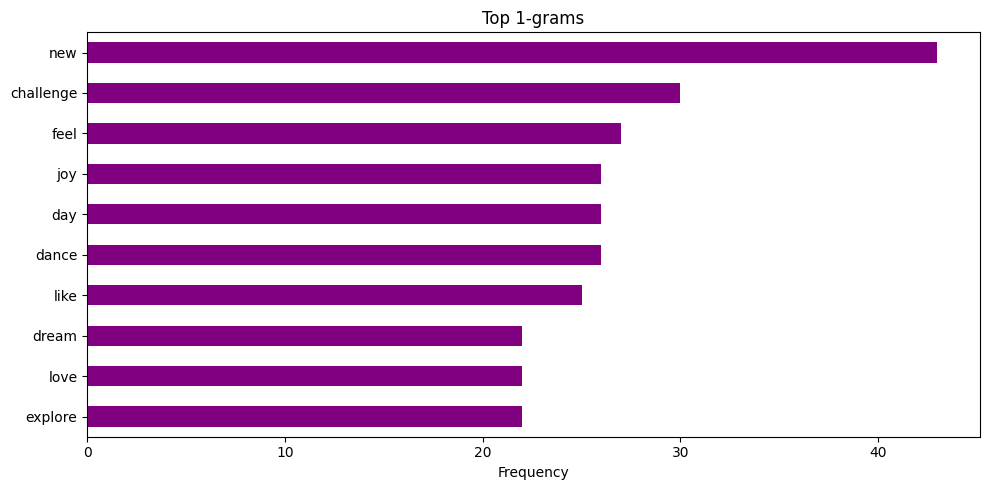

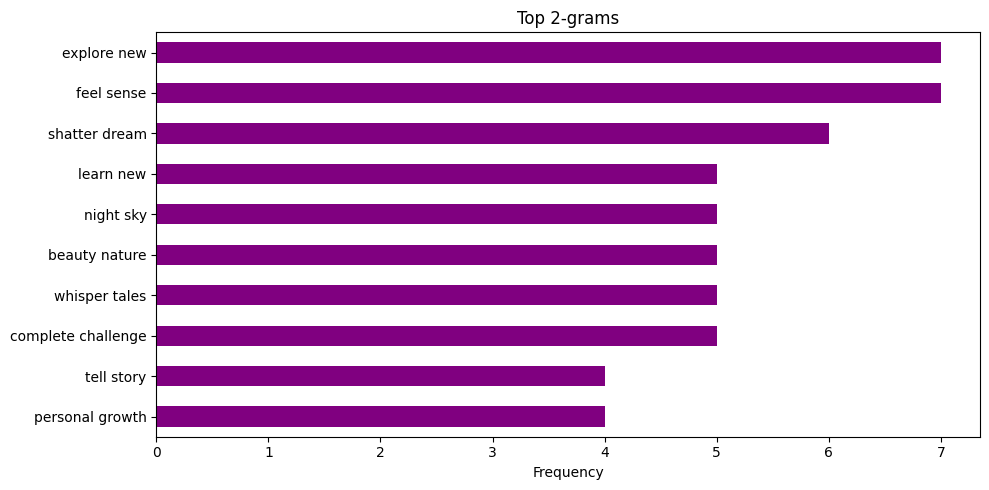

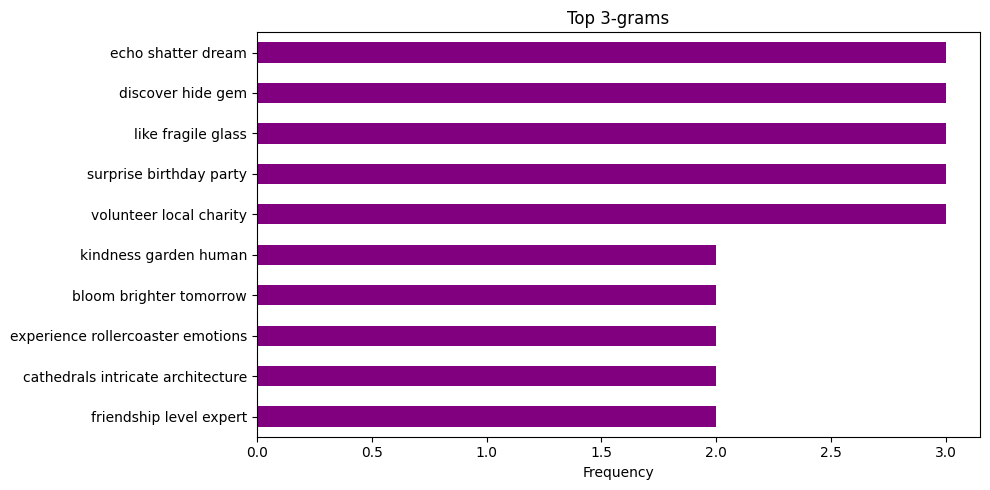

In [72]:
def get_ngrams(texts, n=2, top_k=10):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english')
    X = vec.fit_transform(texts)
    ngram_counts = X.sum(axis=0).A1
    vocab = vec.get_feature_names_out()
    ngram_freq = pd.Series(ngram_counts, index=vocab)
    return ngram_freq.sort_values(ascending=False).head(top_k)

for n in [1, 2, 3]:
    top_ngrams = get_ngrams(final_df['clean_text'].dropna(), n=n)
    plt.figure(figsize=(10, 5))
    top_ngrams.plot(kind='barh', title=f"Top {n}-grams", color='purple')
    plt.gca().invert_yaxis()
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()